In [22]:
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# work with images

import cv2 as cv

# model development
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam


In [14]:
data_path="../data/cancer_dataset.csv"

traindf = pd.read_csv(data_path,header=0)
train_data=shuffle(traindf,random_state=42)
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.25)


In [16]:
train_data.label=train_data.label.astype("string")

In [17]:
train_generator= datagen.flow_from_dataframe(
    dataframe=train_data,
    directory="/media/jacky/data_4tb/Uni/FocusArea/PJ1/",
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(64,64)
)

Found 2922 validated image filenames belonging to 2 classes.


In [18]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory="/media/jacky/data_4tb/Uni/FocusArea/PJ1/",
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=42,
    class_mode="binary",
    target_size=(64,64))

Found 973 validated image filenames belonging to 2 classes.


   Label Counts
1          3451
0           444


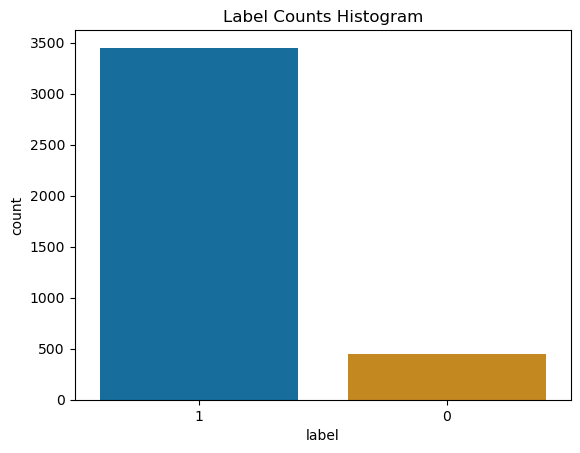

In [20]:
#create histogram
print(pd.DataFrame(data={'Label Counts': train_data['label'].value_counts()}))
sns.countplot(x=train_data['label'], palette='colorblind').set(title='Label Counts Histogram');

In [ ]:
# set ROC AUC as metric
ROC_1 = tf.keras.metrics.AUC()
BATCH_SIZE=100
# use GPU
with tf.device("/gpu:0"):
    
    #create model
    model_one = Sequential()
    
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(MaxPooling2D(pool_size=(2,2)))

    model_one.add(Conv2D(filters=32, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=32, kernel_size=(3,3)))
    model_one.add(AveragePooling2D(pool_size=(2,2)))

    model_one.add(Flatten())
    model_one.add(Dense(1, activation='sigmoid'))
    
    #build model by input size
    model_one.build(input_shape=(BATCH_SIZE, 64, 64, 3))        # original image = (96, 96, 3) 
    
    #compile
    model_one.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1])
    
#quick look at model
model_one.summary()

In [25]:
EPOCHS = 10

# train the model
history_model_one = model_one.fit_generator(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

/tmp/ipykernel_6920/4289168244.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_one = model_one.fit_generator(


Epoch 1/10


2022-11-09 18:29:02.012761: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-09 18:29:18.800625: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


92/92 [==============================] - 106s 888ms/step - loss: 0.3230 - accuracy: 0.8843 - auc_2: 0.7503 - val_loss: 0.2498 - val_accuracy: 0.8911 - val_auc_2: 0.9084
Epoch 2/10
92/92 [==============================] - 45s 495ms/step - loss: 0.2488 - accuracy: 0.9025 - auc_2: 0.8602 - val_loss: 0.2687 - val_accuracy: 0.8972 - val_auc_2: 0.9037
Epoch 3/10
92/92 [==============================] - 47s 509ms/step - loss: 0.2406 - accuracy: 0.9120 - auc_2: 0.8652 - val_loss: 0.3031 - val_accuracy: 0.8736 - val_auc_2: 0.9117
Epoch 4/10
92/92 [==============================] - 39s 430ms/step - loss: 0.2271 - accuracy: 0.9151 - auc_2: 0.8810 - val_loss: 0.2652 - val_accuracy: 0.8767 - val_auc_2: 0.9106
Epoch 5/10
92/92 [==============================] - 52s 568ms/step - loss: 0.2155 - accuracy: 0.9189 - auc_2: 0.8977 - val_loss: 0.2405 - val_accuracy: 0.9034 - val_auc_2: 0.9079
Epoch 6/10
92/92 [==============================] - 39s 422ms/step - loss: 0.2034 - accuracy: 0.9192 - auc_2: 0.910

In [43]:

epoch_arr=np.linspace(1,10,num=10).astype('int')
d={"acc":history_model_one.history['accuracy'],'val_acc':history_model_one.history['val_accuracy']}
df = pd.DataFrame(d)

# sns.set(style='darkgrid')
# sns.lineplot(x='epoch', y='acc',data=df)
# plt.savefig("../result/Accuracy.png")

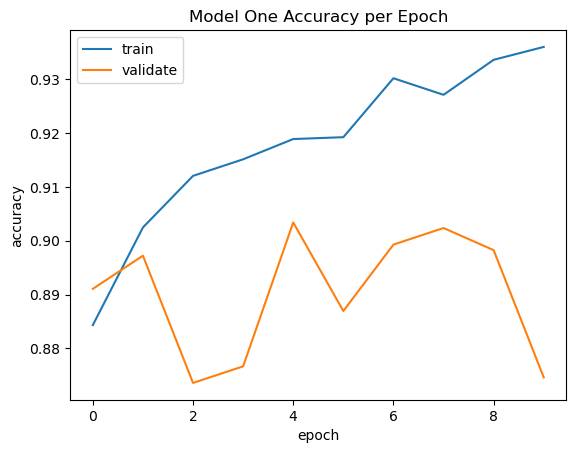

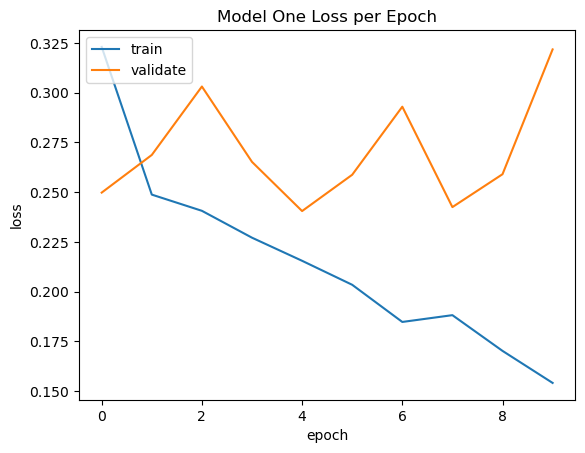

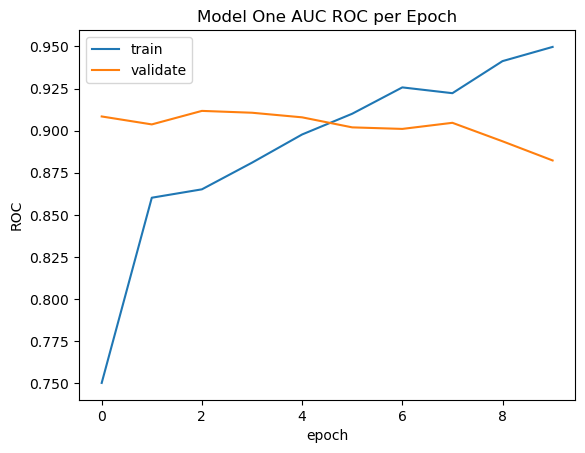

<Figure size 640x480 with 0 Axes>

In [49]:
# plot model accuracy per epoch 
plt.plot(history_model_one.history['accuracy'])
plt.plot(history_model_one.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history_model_one.history['loss'])
plt.plot(history_model_one.history['val_loss'])
plt.title('Model One Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();
plt.savefig("../result/loss.png")


# plot model ROC per epoch
plt.plot(history_model_one.history['auc_2'])
plt.plot(history_model_one.history['val_auc_2'])
plt.title('Model One AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();
plt.savefig("../result/AUC.png")
